# Introduction to Seis4CCS.jl

Seis4CCS.jl https://github.com/slimgroup/Seis4CCS.jl is a simulation-based open-source software framework, designed for large-scale time-lapse seismic monitoring of geological carbon storage. The software framework itself includes the following sections

1. proxy model building
2. fluid-flow simulations
3. rock physics model
4. seismic modeling
5. seismic imaging

which are shown as a workflow chart below.

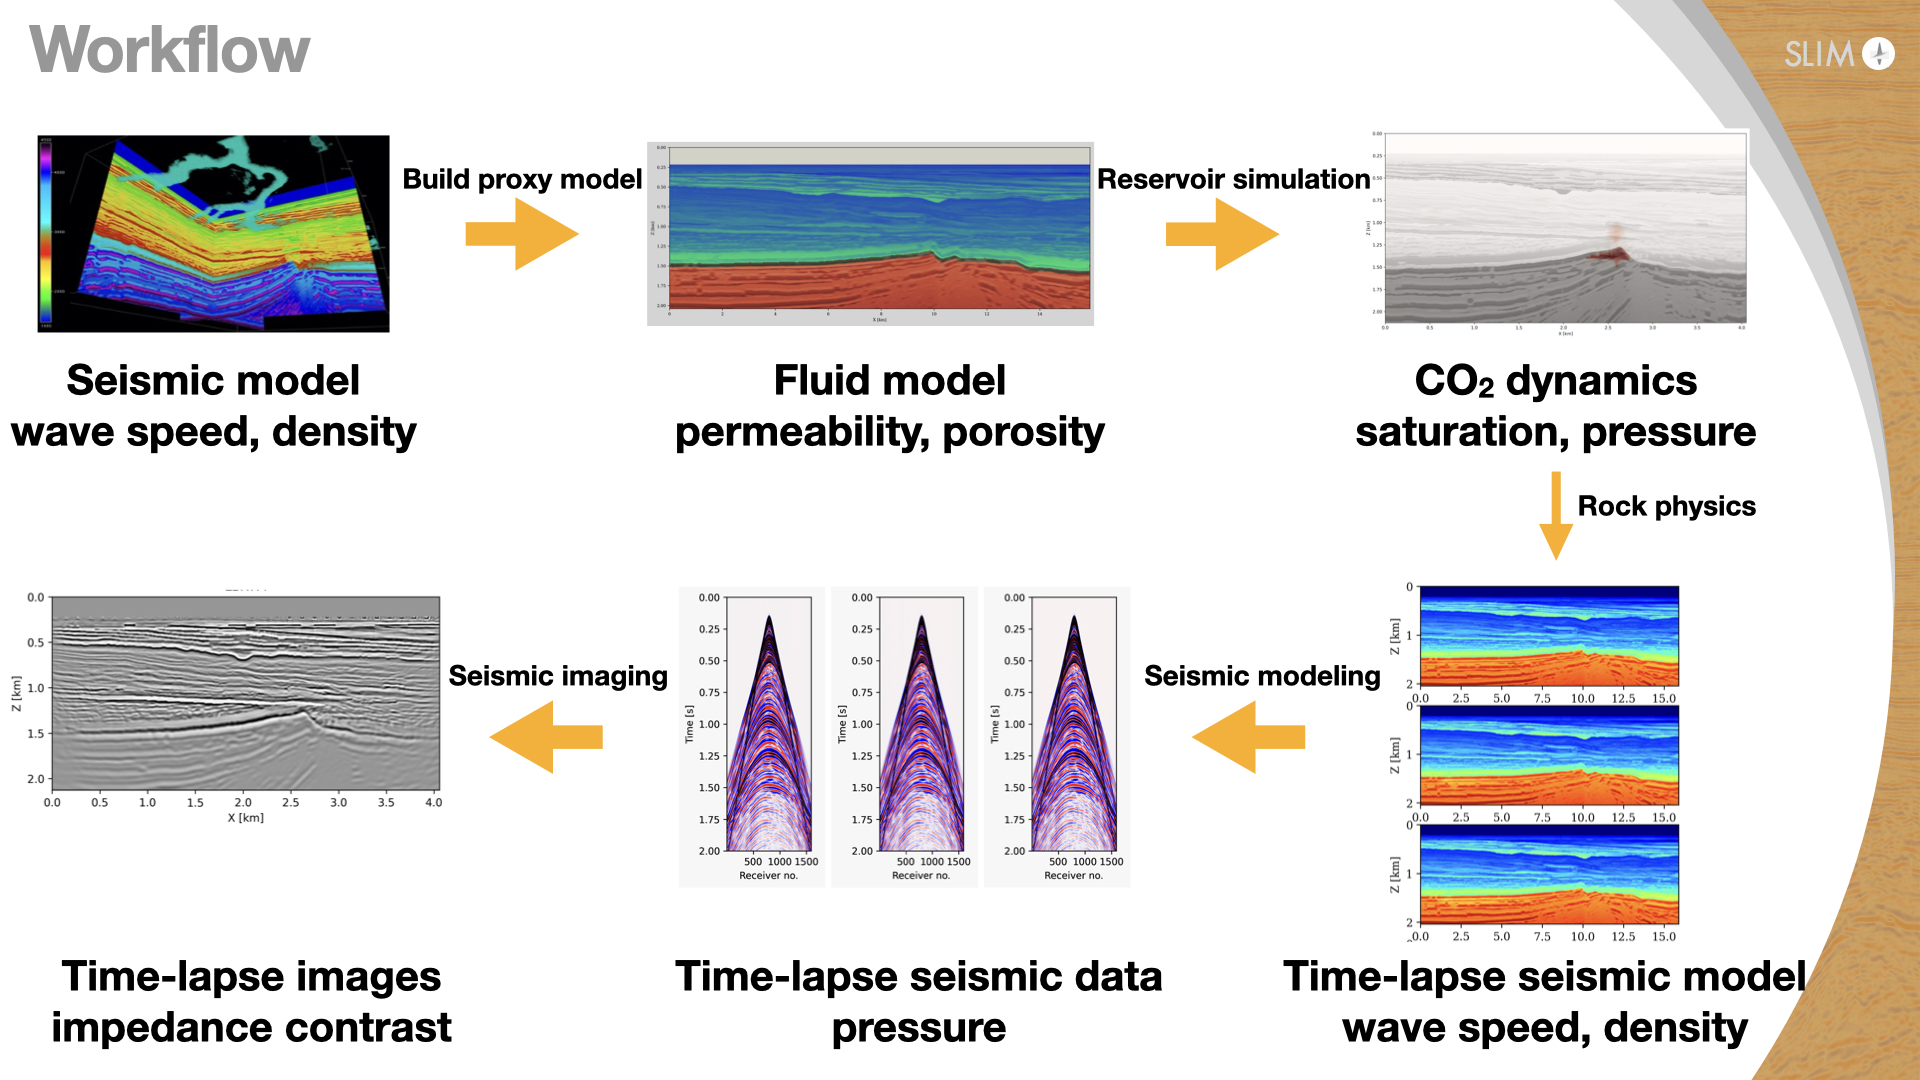

Given the limited time and computing resources in this breakout session, the tutorial here will focus on time-lapse seismic imaging w/ the joint recovery model. More hands-on & detailed tutorials on the entire workflow are provided in the GitHub repository.

## Load the time-lapse model

In [1]:
using PyPlot, JLD2, Images, Random, Statistics, LinearAlgebra, Printf;
using JOLI;
using MECurvelets;
Random.seed!(1234);

In [2]:
JLD2.@load "../data/jrmdata/timelapsevrho64vint.jld2"

3-element Vector{Symbol}:
 :vp_stack
 :rho_stack
 :imp_stack

In [3]:
d = (6.25f0, 6.25f0);     # spacing [m]
n = size(vp_stack[1]);    # model size
extentx = (n[1]-1)*d[1];  # model range
extentz = (n[2]-1)*d[2];  # model depth

Assume we've already generated fluid-flow model from the Compass model, finished the fluid-flow simulations and converted the time-lapse CO2 saturation to the time-lapse velocity (`vp_stack`) and density (`rho_stack`) models, which are stored in the .jld2 file shown above. The `imp_stack` denotes the time-lapse acoustic impedance, as the product of velocity and density. These time-lapse models are in length of 64, corresponding to 64 snapshots in this CCS project. Assume we've collected 3 seismic surveys at snapshot 1 (baseline), snapshot 32 (monitor 1) and snapshot 64 (monitor 2). The acoustic impedance models at these 3 vintages are shown below. (Feel free to use more!)

In [4]:
nv = 3;    # 3 vintages
imp_vint = imp_stack[[1,32,64]];

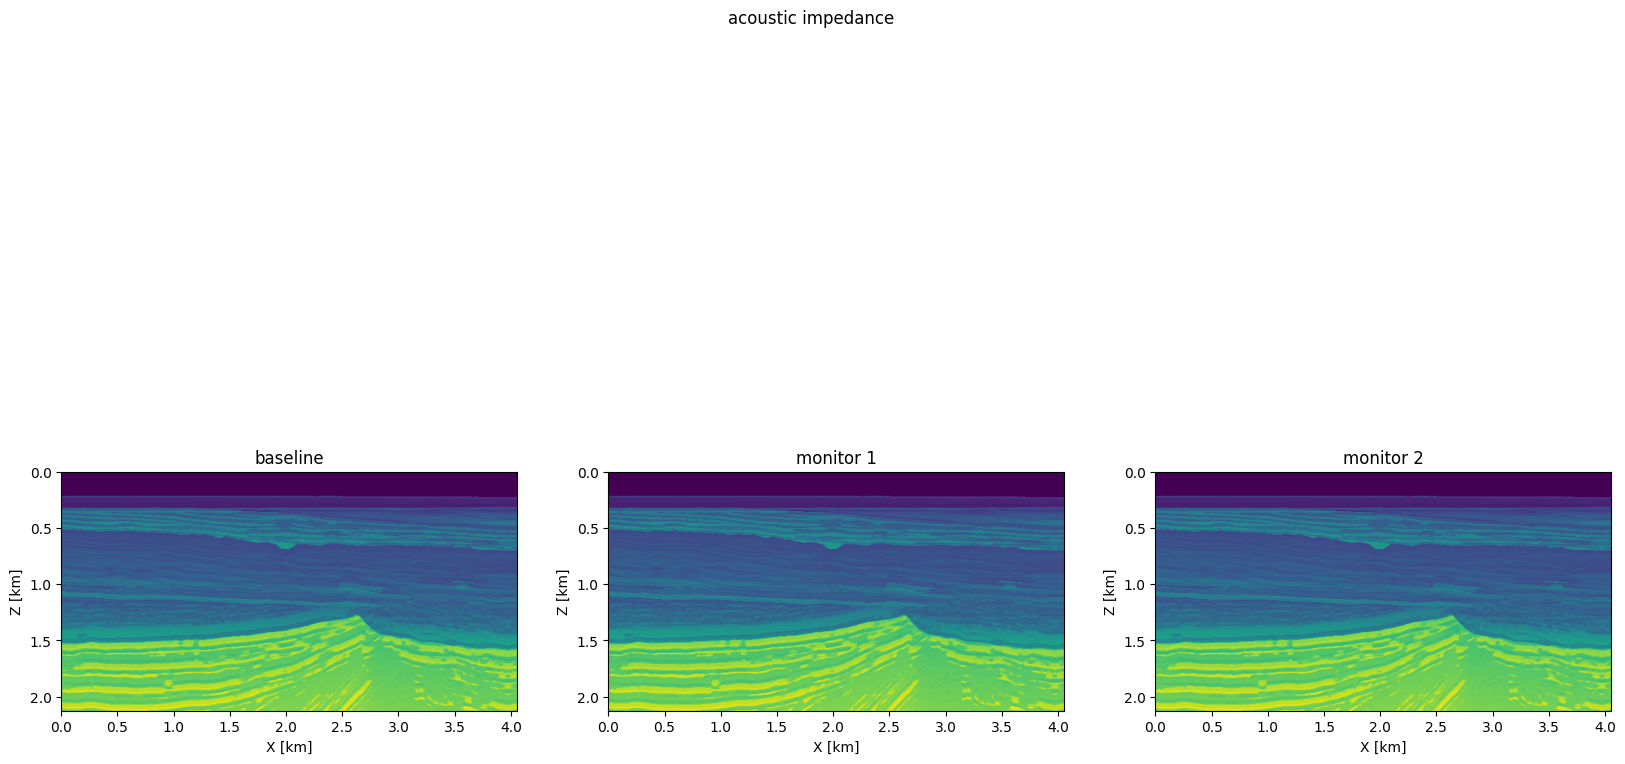

PyObject Text(0.5, 0.98, 'acoustic impedance')

In [5]:
# plot the time-lapse impedance models
figure(figsize=(20,12));
subplot(1,3,1);
imshow(imp_vint[1]',extent=(0,extentx/1f3,extentz/1f3,0));
xlabel("X [km]");ylabel("Z [km]");title("baseline");
subplot(1,3,2);
imshow(imp_vint[2]',extent=(0,extentx/1f3,extentz/1f3,0));
xlabel("X [km]");ylabel("Z [km]");title("monitor 1");
subplot(1,3,3);
imshow(imp_vint[3]',extent=(0,extentx/1f3,extentz/1f3,0));
xlabel("X [km]");ylabel("Z [km]");title("monitor 2");
suptitle("acoustic impedance")

We can see that these impedance models look quite similar, because the effect of CO2 saturation to the acoustic impedance is quite subtle. We can plot the different of them to see the growth of the CO2 plume.

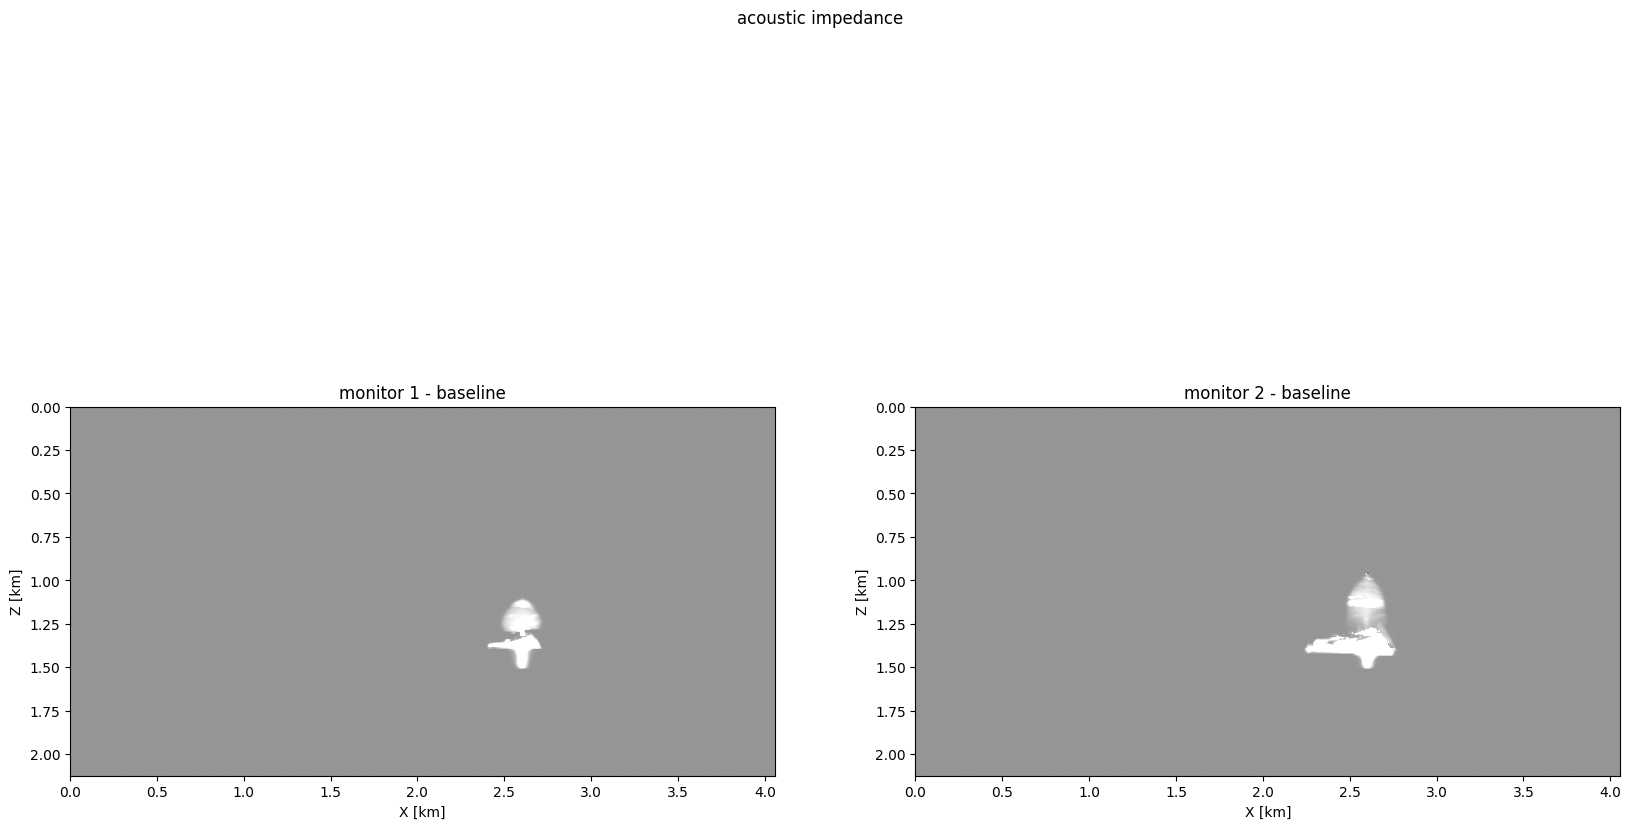

PyObject Text(0.5, 0.98, 'acoustic impedance')

In [6]:
# plot the differences
figure(figsize=(20,12));
subplot(1,2,1);
imshow(imp_vint[2]'-imp_stack[1]',extent=(0,extentx/1f3,extentz/1f3,0),
    vmin=-maximum(imp_stack[end]'-imp_stack[1]'),vmax=maximum(imp_stack[end]'-imp_stack[1]'),cmap="Greys");
xlabel("X [km]");ylabel("Z [km]");title("monitor 1 - baseline");
subplot(1,2,2);
imshow(imp_vint[3]'-imp_stack[1]',extent=(0,extentx/1f3,extentz/1f3,0),
    vmin=-maximum(imp_stack[end]'-imp_stack[1]'),vmax=maximum(imp_stack[end]'-imp_stack[1]'),cmap="Greys");
xlabel("X [km]");ylabel("Z [km]");title("monitor 2 - baseline");
suptitle("acoustic impedance")

## Seismic imaging

In seismic imaging, we assume to have access to a background impedance model that is smoothed from the ground truth impedance model at the baseline. We can do this by convolving the ground truth impedance model with a Gaussian kernel.

In [7]:
imp0 = convert(Array{Float32,2},imfilter(imp_vint[1], Kernel.gaussian(10)));

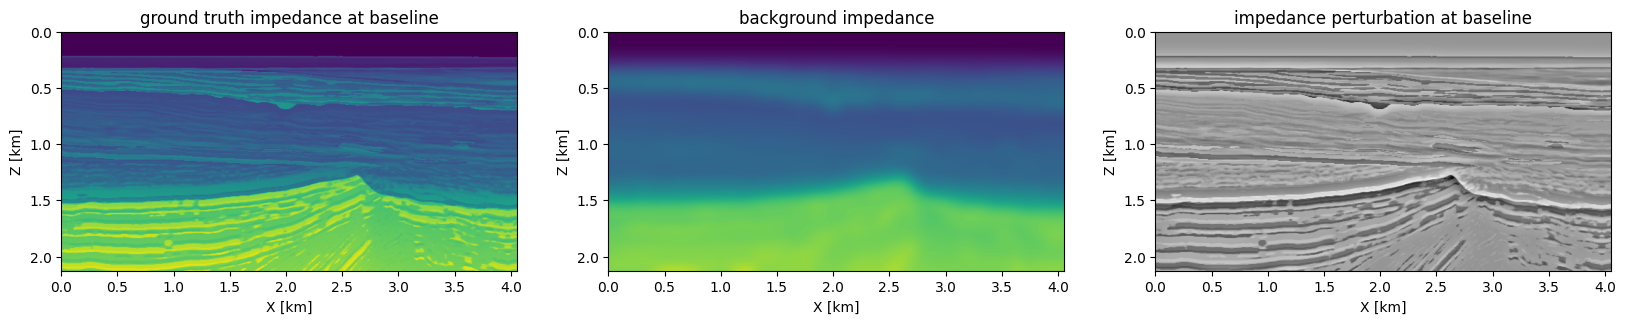

In [8]:
figure(figsize=(20,12));
subplot(1,3,1);
imshow(imp_vint[1]',extent=(0,extentx/1f3,extentz/1f3,0),
    vmin=minimum(imp_vint[1]),vmax=maximum(imp_vint[1]));
xlabel("X [km]");ylabel("Z [km]");title("ground truth impedance at baseline");
subplot(1,3,2);
imshow(imp0',extent=(0,extentx/1f3,extentz/1f3,0),
    vmin=minimum(imp_vint[1]),vmax=maximum(imp_vint[1]));
xlabel("X [km]");ylabel("Z [km]");title("background impedance");
subplot(1,3,3);
imshow(imp_vint[1]'-imp0',extent=(0,extentx/1f3,extentz/1f3,0),
    vmin=-maximum(imp_vint[1]'-imp0'),vmax=maximum(imp_vint[1]'-imp0'),cmap="Greys");
xlabel("X [km]");ylabel("Z [km]");title("impedance perturbation at baseline");

The seismic imaging problem, can be stated as

$$\min_{\mathbf{x}} \frac{1}{2}\|\mathbf{Ax}-\mathbf{b}\|_2^2$$

where $\mathbf{A}$ is the born modeling (demigration) operator with a given background model, which generates linearized data $\mathbf{b}$ given the acoustic impedance perturbation $\mathbf{x}$.

To show a small demo in a short period of time, we can replace the born modeling operator $\mathbf{A}$ by the compressive sensing matrix, defined by

In [9]:
subsamp = 0.25f0
A = joRestriction(prod(n), sort(randperm(prod(n))[1:Int(round(subsamp*prod(n)))]); DDT=Float32, RDT=Float32)*
    joRomberg(n[1],n[2]; DDT=Float32, RDT=Float32);
show(A)

Type: typename(joLinearOperator)
Name: (joRestriction*joRomberg)
Size: (55412, 221650)
 DDT: Float32
 RDT: Float32


In the definition above, `joRomberg` is a random convolution matrix$^1$ and `joRestriction` is a restriction operator with 25% subsampling ratio.

$^1$Romberg, Justin. "Compressive sensing by random convolution." SIAM Journal on Imaging Sciences 2.4 (2009): 1098-1128.

Then, we can generate the linear data by $\mathbf{b}=\mathbf{Ax}^{\ast}$

In [10]:
xstar = vec(imp_vint[1]-imp0);
b = A*xstar;

### Linearized Bregman

Notice that seismic image is intrinsically sparse in curvelet domain, we can use Linearized Bregman algorithm to invert this linear system while promoting sparsity of the solution in curvelet domain, i.e.

$$\min_\mathbf{x} \|\mathbf{Cx}\|_1 + \frac{1}{2\lambda}\|\mathbf{Cx}\|_2^2 \quad \text{s.t.}\quad \|\mathbf{Ax}-\mathbf{b}\|_2\leq \sigma^2$$

First, we define the mirror-extended curvelet transform

In [11]:
C = joMECurvelet2D(n; DDT=Float32, RDT=Complex{Float32});
show(C)

Mirror extended curvelet transform for image of size (650, 341). 6 scales, 8 angles


Then the Linearized Bregman algorithm can be simply implemented by

In [12]:
x = zeros(Float32, size(C,2));
z = zeros(Float32, size(C,1));
niter = 16;

In [13]:
for j = 1:niter
    r = A*x-b
    g = C*A'*r
    t = norm(r)^2/norm(g)^2
    z -= t*g
    (j==1) && (global lambda = Float32(quantile(abs.(z), 1.)))   # set threshold
    x = C'*soft_thresholding(z, lambda)
    @printf("At iteration %d function value is %2.2e threshold is %2.2e \n", j, 0.5f0*norm(r)^2, lambda);
    flush(Base.stdout);
end

At iteration 1 function value is 1.08e+04 threshold is 2.56e+00 
At iteration 2 function value is 1.08e+04 threshold is 2.56e+00 
At iteration 3 function value is 1.05e+04 threshold is 2.56e+00 
At iteration 4 function value is 9.53e+03 threshold is 2.56e+00 
At iteration 5 function value is 8.37e+03 threshold is 2.56e+00 
At iteration 6 function value is 7.18e+03 threshold is 2.56e+00 
At iteration 7 function value is 6.04e+03 threshold is 2.56e+00 
At iteration 8 function value is 5.05e+03 threshold is 2.56e+00 
At iteration 9 function value is 4.23e+03 threshold is 2.56e+00 
At iteration 10 function value is 3.56e+03 threshold is 2.56e+00 
At iteration 11 function value is 3.03e+03 threshold is 2.56e+00 
At iteration 12 function value is 2.60e+03 threshold is 2.56e+00 
At iteration 13 function value is 2.25e+03 threshold is 2.56e+00 
At iteration 14 function value is 1.97e+03 threshold is 2.56e+00 
At iteration 15 function value is 1.74e+03 threshold is 2.56e+00 
At iteration 16 fun

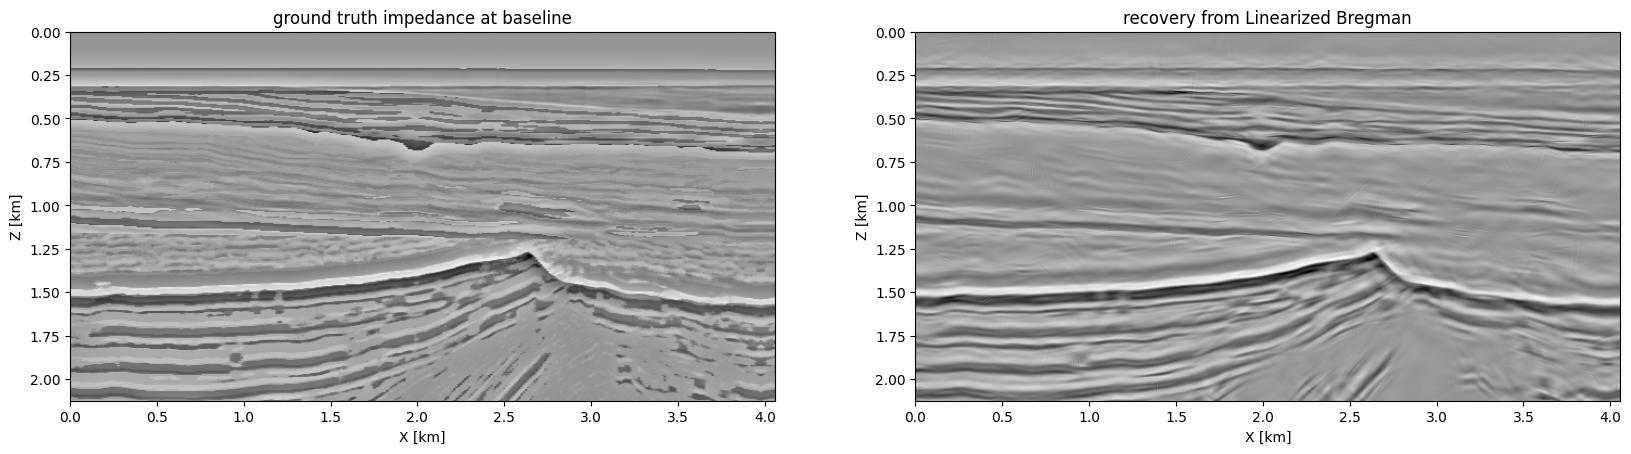

In [14]:
figure(figsize=(20,12));
subplot(1,2,1);
imshow(imp_vint[1]'-imp0',extent=(0,extentx/1f3,extentz/1f3,0),
    vmin=-maximum(imp_vint[1]'-imp0'),vmax=maximum(imp_vint[1]'-imp0'),cmap="Greys");
xlabel("X [km]");ylabel("Z [km]");title("ground truth impedance at baseline");
subplot(1,2,2);
imshow(reshape(x,n)',extent=(0,extentx/1f3,extentz/1f3,0),
    vmin=-maximum(x),vmax=maximum(x),cmap="Greys");
xlabel("X [km]");ylabel("Z [km]");title("recovery from Linearized Bregman");

## Time-lapse seismic imaging

Seismic monitoring of CO2 sequestration requires imaging of time-lapse seismic data collected at multiple vintages.

## Independent recovery

To take a naive look at the time-lapse seismic imaging, we are inverting

$$\mathbf{Ax}=\mathbf{b}$$

where

$$\mathbf{A} = \begin{bmatrix}  \mathbf{A}_1 &  &   & \\  & \mathbf{A}_2 &  &  \\
  &   & \cdots &   \\
  &   &   & \mathbf{A}_{n_v}
\end{bmatrix}$$

relates the acoustic impedance perturbation at the different vintages

$$\mathbf{x} = \left[\mathbf{x}_1,\cdots,\mathbf{x}_{n_v}\right]$$

to the linear data collected at the different vintages

$$\mathbf{b} = \left[\mathbf{b}_1,\cdots,\mathbf{b}_{n_v}\right]$$

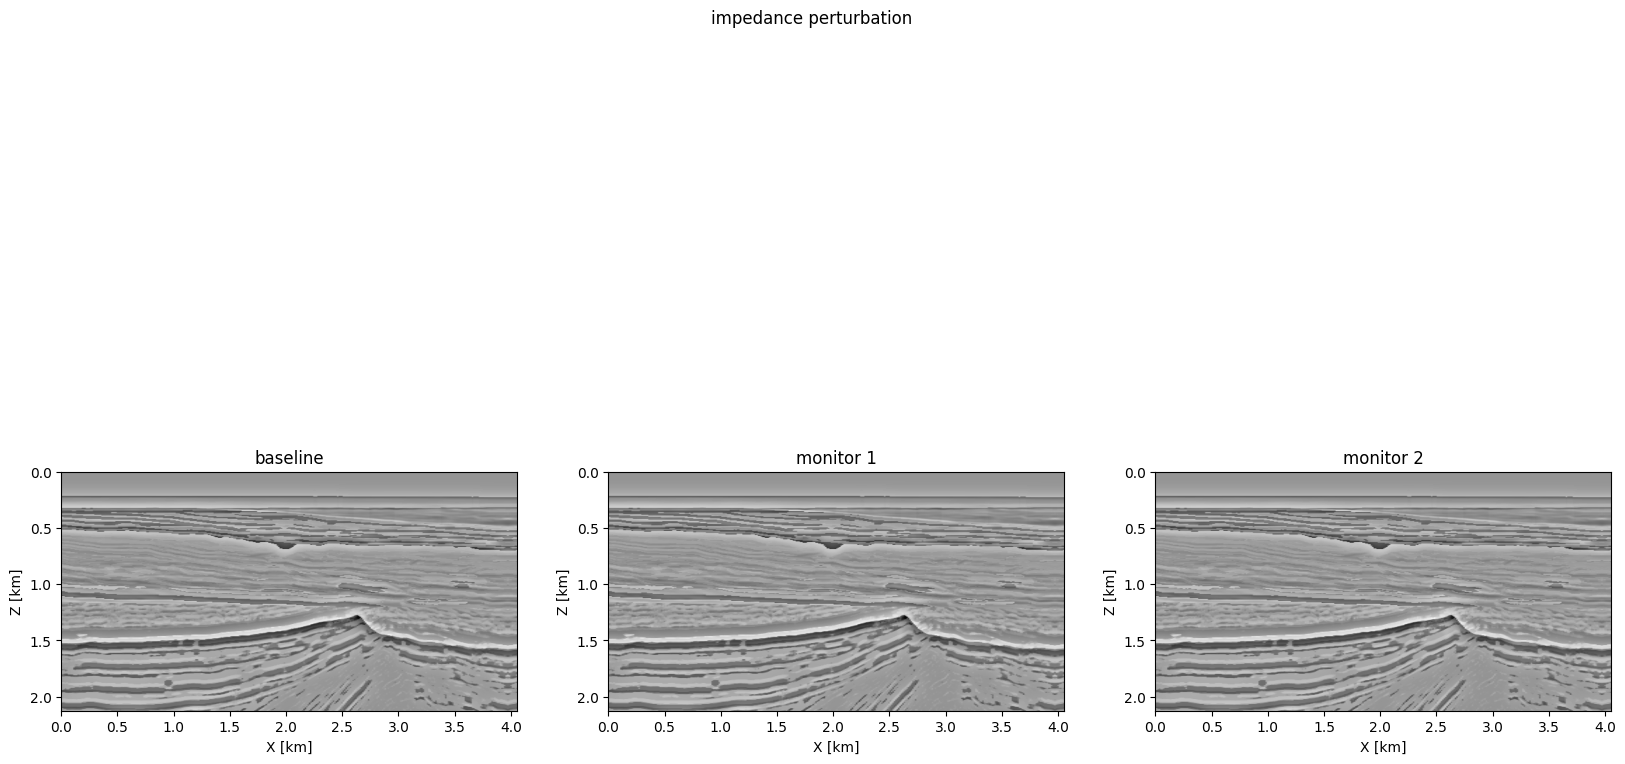

PyObject Text(0.5, 0.98, 'impedance perturbation')

In [15]:
# plot the ground truth impedance perturbations

xstar = [vec(imp_vint[i] - imp0) for i = 1:nv];
figure(figsize=(20,12));
subplot(1,3,1);
imshow(reshape(xstar[1],n)',extent=(0,extentx/1f3,extentz/1f3,0),
    vmin=-maximum(xstar[1]),vmax=maximum(xstar[1]),cmap="Greys");
xlabel("X [km]");ylabel("Z [km]");title("baseline");
subplot(1,3,2);
imshow(reshape(xstar[2],n)',extent=(0,extentx/1f3,extentz/1f3,0),
    vmin=-maximum(xstar[1]),vmax=maximum(xstar[1]),cmap="Greys");
xlabel("X [km]");ylabel("Z [km]");title("monitor 1");
subplot(1,3,3);
imshow(reshape(xstar[3],n)',extent=(0,extentx/1f3,extentz/1f3,0),
    vmin=-maximum(xstar[1]),vmax=maximum(xstar[1]),cmap="Greys");
xlabel("X [km]");ylabel("Z [km]");title("monitor 2");
suptitle("impedance perturbation")

Again, these images look quite similar to each other. We can look at the subtraction of these images to follow the growth of the plume.

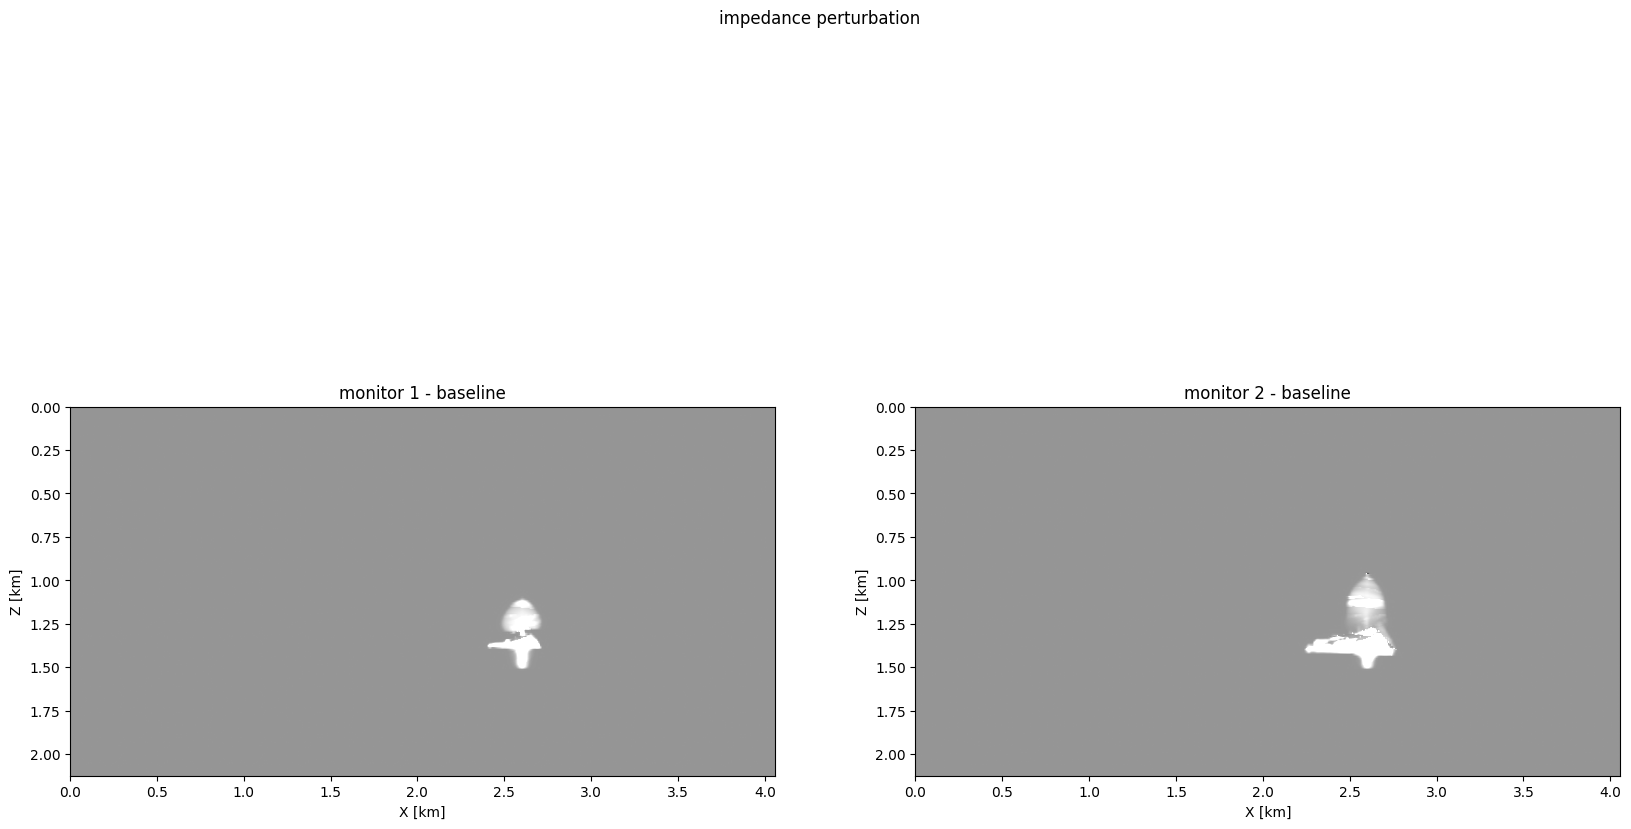

In [16]:
# plot the differences

figure(figsize=(20,12));
subplot(1,2,1);
imshow(reshape(xstar[2]-xstar[1],n)',extent=(0,extentx/1f3,extentz/1f3,0),
    vmin=-maximum(xstar[end]-xstar[1]),vmax=maximum(xstar[end]-xstar[1]),cmap="Greys");
xlabel("X [km]");ylabel("Z [km]");title("monitor 1 - baseline");
subplot(1,2,2);
imshow(reshape(xstar[3]-xstar[1],n)',extent=(0,extentx/1f3,extentz/1f3,0),
    vmin=-maximum(xstar[end]-xstar[1]),vmax=maximum(xstar[end]-xstar[1]),cmap="Greys");
xlabel("X [km]");ylabel("Z [km]");title("monitor 2 - baseline");
suptitle("impedance perturbation");

We will generate linear data for each vintage with different linear operators.

In [17]:
subsamp = 0.25f0;
A = [joRestriction(prod(n), sort(randperm(prod(n))[1:Int(round(subsamp*prod(n)))]); DDT=Float32, RDT=Float32)*
    joRomberg(n[1],n[2]; DDT=Float32, RDT=Float32) for i = 1:nv];
b = [A[i]*xstar[i] for i = 1:nv];

And then, we use Linearized Bregman to invert the linear system.

In [18]:
x = [zeros(Float32, size(C,2)) for i = 1:nv];
u = [zeros(Complex{Float32}, size(C,1)) for i = 1:nv];

In [19]:
for j = 1:niter
    r = [A[i]*x[i]-b[i] for i = 1:nv]
    g = [C*A[i]'*r[i] for i = 1:nv]
    t = norm(r)^2/norm(g)^2
    u -= t*g
    (j==1) && (global lambda = Float32(quantile(abs.(u[1]), 1.)))
    x = [C'*soft_thresholding(u[i], lambda) for i = 1:nv]
    @printf("At iteration %d function value is %2.2e threshold is %2.2e \n", j, 0.5f0*norm(r)^2, lambda);
    flush(Base.stdout);
end

At iteration 1 function value is 3.21e+04 threshold is 2.52e+00 
At iteration 2 function value is 3.21e+04 threshold is 2.52e+00 
At iteration 3 function value is 3.10e+04 threshold is 2.52e+00 
At iteration 4 function value is 2.83e+04 threshold is 2.52e+00 
At iteration 5 function value is 2.48e+04 threshold is 2.52e+00 
At iteration 6 function value is 2.13e+04 threshold is 2.52e+00 
At iteration 7 function value is 1.79e+04 threshold is 2.52e+00 
At iteration 8 function value is 1.49e+04 threshold is 2.52e+00 
At iteration 9 function value is 1.25e+04 threshold is 2.52e+00 
At iteration 10 function value is 1.05e+04 threshold is 2.52e+00 
At iteration 11 function value is 8.97e+03 threshold is 2.52e+00 
At iteration 12 function value is 7.72e+03 threshold is 2.52e+00 
At iteration 13 function value is 6.69e+03 threshold is 2.52e+00 
At iteration 14 function value is 5.86e+03 threshold is 2.52e+00 
At iteration 15 function value is 5.17e+03 threshold is 2.52e+00 
At iteration 16 fun

In the end, we want to look at the subtraction of these images to follow the growth of the plume. We can use NRMS values to quantitatively evaluate repeatability of the baseline recovery and monitor recovery at non-plume locations

$$\text{NRMS}(\mathbf{x}_1,\mathbf{x}_j)=200\times\frac{\|\mathbf{x}_1-\mathbf{x}_j\|_2}{\|\mathbf{x}_1+\mathbf{x}_j\|_2}$$

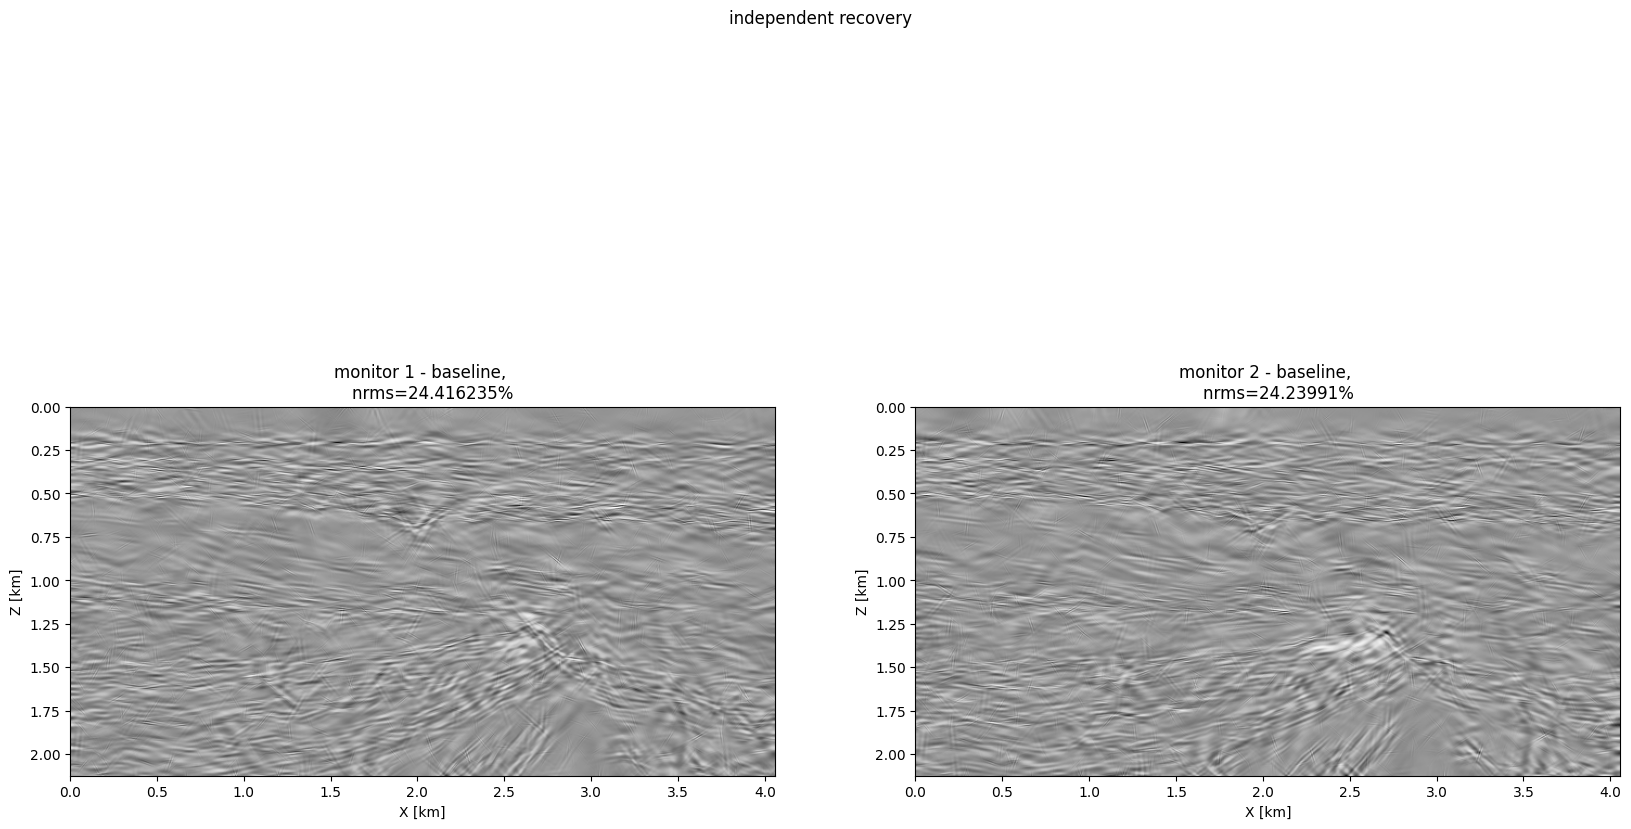

In [20]:
# plot results from independent recovery
figure(figsize=(20,12));
subplot(1,2,1);
imshow(reshape(x[2]-x[1],n)',extent=(0,extentx/1f3,extentz/1f3,0),
    vmin=-maximum(x[end]-x[1]),vmax=maximum(x[end]-x[1]),cmap="Greys");
xlabel("X [km]");ylabel("Z [km]");title("monitor 1 - baseline, 
    nrms=$(200*norm(reshape(x[2]-x[1],n)[1:300,:])/norm(reshape(x[2]+x[1],n)[1:300,:]))%");
subplot(1,2,2);
imshow(reshape(x[3]-x[1],n)',extent=(0,extentx/1f3,extentz/1f3,0),
    vmin=-maximum(x[end]-x[1]),vmax=maximum(x[end]-x[1]),cmap="Greys");
xlabel("X [km]");ylabel("Z [km]");title("monitor 2 - baseline, 
    nrms=$(200*norm(reshape(x[3]-x[1],n)[1:300,:])/norm(reshape(x[3]+x[1],n)[1:300,:]))%");
suptitle("independent recovery");

We can see that there are a lot of artifacts in the image and it's hard to see CO2 leak over the seal. NRMS values are also quite high (about 24%).

## Joint recovery model

To exploit the shared information in different vintages, we can recover these seismic images through the joint recovery model, i.e. inverting

$$\mathbf{\tilde{A}z}=\mathbf{b}$$

where

$$\tilde{\mathbf{A}} = \mathbf{A\Gamma}$$ and

$$\mathbf{\Gamma} = \begin{bmatrix}  \color{red}{\frac{1}{\gamma}\mathbf{I}} & \mathbf{I} &  &  &  \\ \color{red}{\frac{1}{\gamma}\mathbf{I}} &  & \mathbf{I} &  & \\
\color{red}{\cdots} &  &  & \cdots & \\
\color{red}{\frac{1}{\gamma}\mathbf{I}} &  & &  & \mathbf{I}
\end{bmatrix}$$

relates

$$\mathbf{z} = \left[\color{red}{\mathbf{z}_0^\top},\mathbf{z}_1^\top,\cdots,\mathbf{z}_{n_v}^\top\right]^\top$$

collecting common component $\color{red}{\mathbf{z}_0}$ and innovations components $\mathbf{z}_j$ to $\mathbf{x}$ by

$$\mathbf{\Gamma z}=\mathbf{x}$$


In [21]:
z = [zeros(Float32, size(C,2)) for i = 1:nv+1];
u = [zeros(Complex{Float32}, size(C,1)) for i = 1:nv+1];
γ = Float32(sqrt(nv));

In [22]:
for j = 1:niter
    x = [1f0/γ*z[1]+z[i] for i = 2:nv+1]
    r = [A[i]*x[i]-b[i] for i = 1:nv]
    g = [C*A[i]'*r[i] for i = 1:nv]
    g = [1f0/γ*sum(g), g...]
    t = norm(r)^2/norm(g)^2
    u -= t*g
    (j==1) && (global lambda1 = Float32(quantile(abs.(u[1]), 1.)))
    (j==1) && (global lambda2 = Float32(maximum([quantile(abs.(u[i]), 1.) for i = 2:nv+1])))
    z[1] = C'*soft_thresholding(u[1], lambda1)
    z[2:end] = [C'*soft_thresholding(u[i], lambda2) for i = 2:nv+1]
    @printf("At iteration %d function value is %2.2e \n", j, 0.5f0*norm(r)^2);
    flush(Base.stdout);
end

At iteration 1 function value is 3.21e+04 
At iteration 2 function value is 3.21e+04 
At iteration 3 function value is 3.06e+04 
At iteration 4 function value is 2.73e+04 
At iteration 5 function value is 2.33e+04 
At iteration 6 function value is 1.95e+04 
At iteration 7 function value is 1.60e+04 
At iteration 8 function value is 1.32e+04 
At iteration 9 function value is 1.10e+04 
At iteration 10 function value is 9.35e+03 
At iteration 11 function value is 8.01e+03 
At iteration 12 function value is 6.94e+03 
At iteration 13 function value is 6.08e+03 
At iteration 14 function value is 5.38e+03 
At iteration 15 function value is 4.81e+03 
At iteration 16 function value is 4.32e+03 


In [23]:
x = [1f0/γ*z[1]+z[i] for i = 2:nv+1];    # convert common/innovation components to images

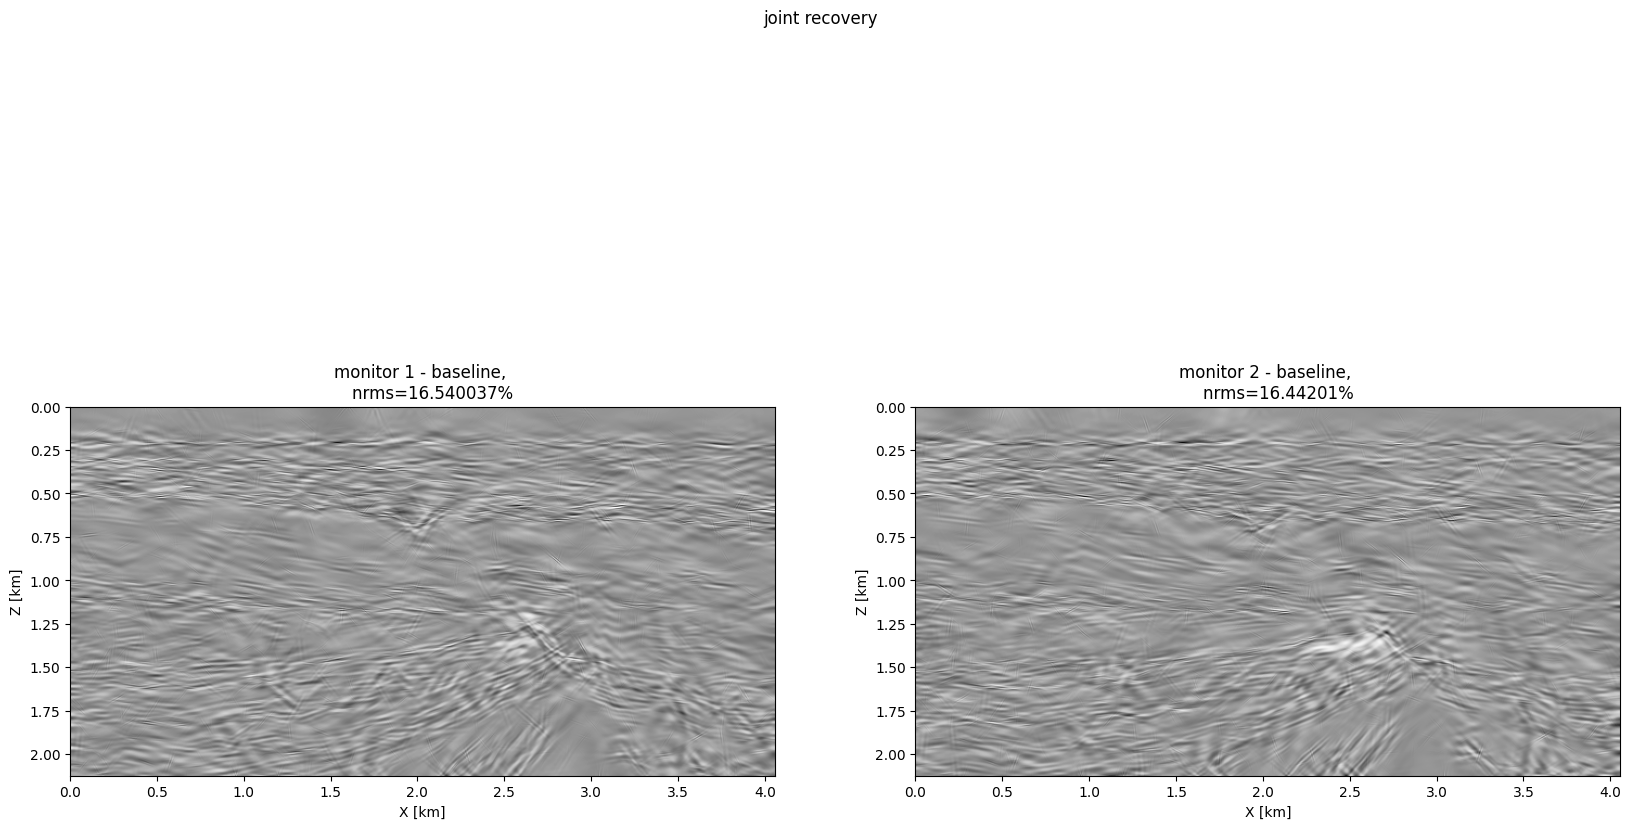

In [24]:
# plot results from joint recovery
figure(figsize=(20,12));
subplot(1,2,1);
imshow(reshape(x[2]-x[1],n)',extent=(0,extentx/1f3,extentz/1f3,0),
    vmin=-maximum(x[end]-x[1]),vmax=maximum(x[end]-x[1]),cmap="Greys");
xlabel("X [km]");ylabel("Z [km]");title("monitor 1 - baseline, 
    nrms=$(200*norm(reshape(x[2]-x[1],n)[1:300,:])/norm(reshape(x[2]+x[1],n)[1:300,:]))%");
subplot(1,2,2);
imshow(reshape(x[3]-x[1],n)',extent=(0,extentx/1f3,extentz/1f3,0),
    vmin=-maximum(x[end]-x[1]),vmax=maximum(x[end]-x[1]),cmap="Greys");
xlabel("X [km]");ylabel("Z [km]");title("monitor 2 - baseline, 
    nrms=$(200*norm(reshape(x[3]-x[1],n)[1:300,:])/norm(reshape(x[3]+x[1],n)[1:300,:]))%");
suptitle("joint recovery");

We can see that the plume area is slightly more distinguishable from the artifacts, and the NRMS value is also lower (about 16%), indicating the recovered images for different vintages are more repeatable. We only use 16 iterations here due to the time constraints, but more iterations are needed for fully convergence.

## Real-time monitoring of the plume -- incremental JRM

In practice, we cannot wait to collect all seismic surveys in the duration of the CCS project and then do the recovery. In order to detect the CO2 leakage in the early period of time, once a new seismic survey is collected from the field, we will do a joint recovery using the seismic surveys from the baseline to the current monitor survey. E.g. when we have 2 surveys, we do a joint recovery using these 2 surveys; when we receive a 3rd survey, we do a joint recovery using these 3 surveys ...

Therefore, we can use Linearized Bregman to do joint recovery whenever a new survey comes in, which is shown as below.

At vintage 2 iteration 1 function value is 2.13e+04 
At vintage 2 iteration 2 function value is 2.13e+04 
At vintage 2 iteration 3 function value is 2.04e+04 
At vintage 2 iteration 4 function value is 1.83e+04 
At vintage 2 iteration 5 function value is 1.58e+04 
At vintage 2 iteration 6 function value is 1.33e+04 
At vintage 2 iteration 7 function value is 1.10e+04 
At vintage 2 iteration 8 function value is 9.10e+03 
At vintage 2 iteration 9 function value is 7.60e+03 
At vintage 2 iteration 10 function value is 6.42e+03 
At vintage 2 iteration 11 function value is 5.49e+03 
At vintage 2 iteration 12 function value is 4.75e+03 
At vintage 2 iteration 13 function value is 4.15e+03 
At vintage 2 iteration 14 function value is 3.66e+03 
At vintage 2 iteration 15 function value is 3.26e+03 
At vintage 2 iteration 16 function value is 2.92e+03 
At vintage 3 iteration 1 function value is 3.21e+04 
At vintage 3 iteration 2 function value is 3.21e+04 
At vintage 3 iteration 3 function value

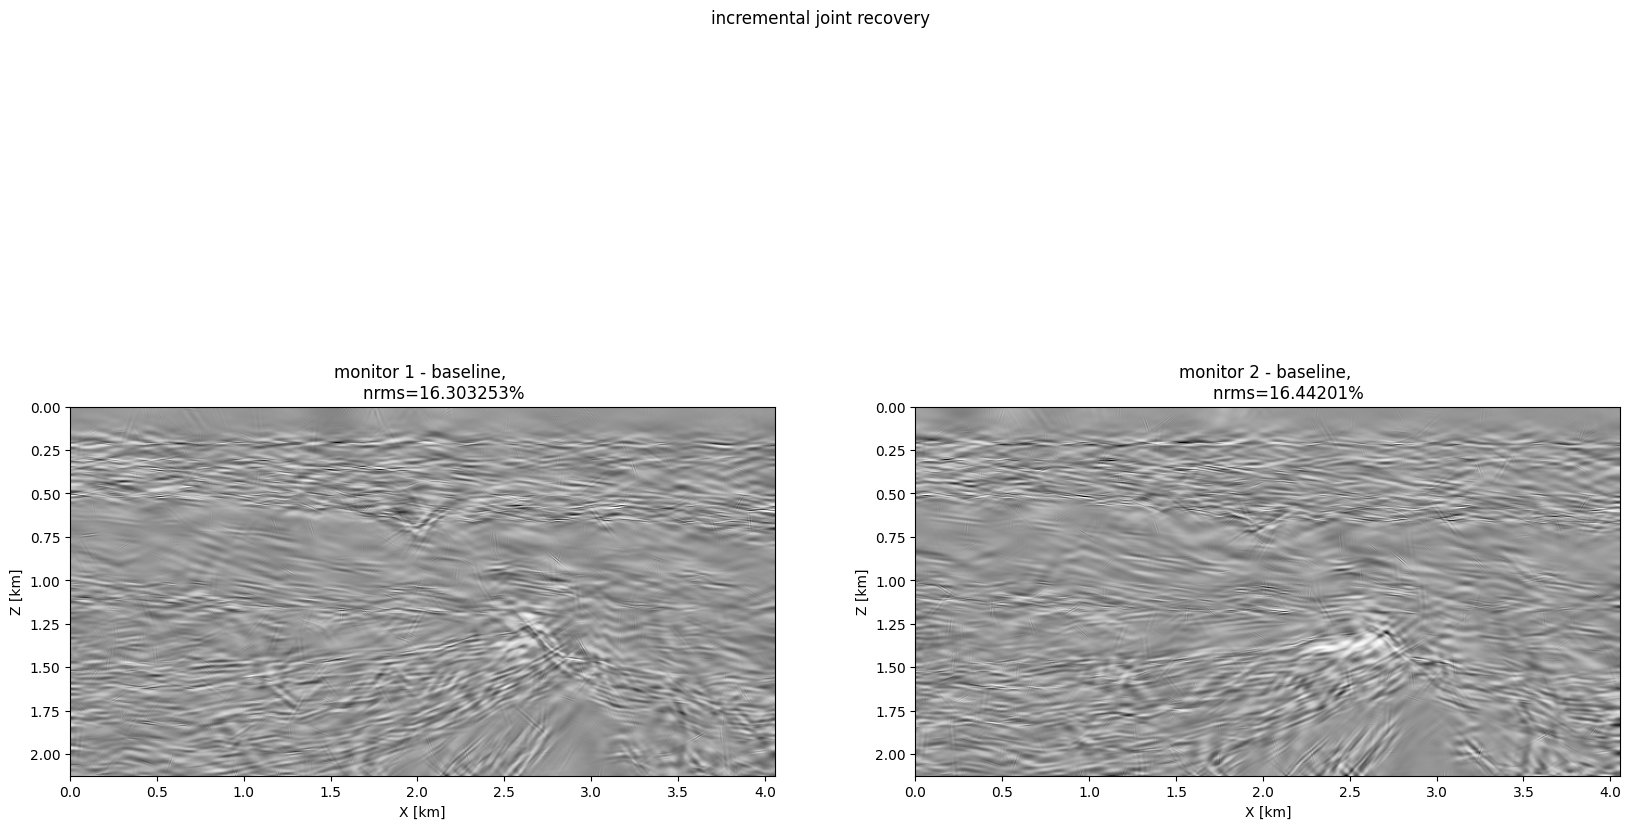

In [25]:
figure(figsize=(20,12));
for L = 2:nv    #whenever we received a new survey
    z = [zeros(Float32, size(C,2)) for i = 1:L+1]
    u = [zeros(Complex{Float32}, size(C,1)) for i = 1:L+1]
    γ = Float32(sqrt(L));
    for j = 1:niter
        x = [1f0/γ*z[1]+z[i] for i = 2:L+1]
        r = [A[i]*x[i]-b[i] for i = 1:L]
        g = [C*A[i]'*r[i] for i = 1:L]
        g = [1f0/γ*sum(g), g...]
        t = norm(r)^2/norm(g)^2
        u -= t*g
        (j==1) && (global lambda1 = Float32(quantile(abs.(u[1]), 1.)))
        (j==1) && (global lambda2 = Float32(maximum([quantile(abs.(u[i]), 1.) for i = 2:L+1])))
        z[1] = C'*soft_thresholding(u[1], lambda1)
        z[2:end] = [C'*soft_thresholding(u[i], lambda2) for i = 2:L+1]
        @printf("At vintage %d iteration %d function value is %2.2e \n", L, j, 0.5f0*norm(r)^2);
        flush(Base.stdout);
    end
    x = [1f0/γ*z[1]+z[i] for i = 2:L+1];
    (L==2) && (global clip=maximum(x[L]-x[1]))
    subplot(1,nv-1,L-1)
    imshow(reshape(x[L]-x[1],n)',extent=(0,extentx/1f3,extentz/1f3,0),
        vmin=-clip,vmax=clip,cmap="Greys");
        xlabel("X [km]");ylabel("Z [km]");title("monitor $(L-1) - baseline, 
        nrms=$(200*norm(reshape(x[L]-x[1],n)[1:300,:])/norm(reshape(x[L]+x[1],n)[1:300,:]))%");
end
suptitle("incremental joint recovery");

## Real-time monitoring of the plume -- incremental JRM w/ reweighted $\ell_1$

JRM already exploits the shared information from all collected surveys from baseline to the latest monitor to improve the recovery of the plume. Furthermore, we can also exploit the prior information, i.e. when a new (say 3rd) survey comes in, we can take advantage of the information from the joint recovery results on 1st and 2nd surveys. Given that common component and innovation components are approximately sparse in curvelet domain and they share most of the locations of the non-zero curvelet entries (support), we can make an assumption that the new innovation component (from the new survey) also shares the same locations of non-zero curvelet entries. Therefore, we can adopt a weighted $\ell_1$ scheme with lower weight (0.5) on the (estimated) support region to reduce penalization on known curvelet coefficients, and normal weight (1) on the non-support region.

The process is shown below:

In [26]:
import MECurvelets.soft_thresholding;
function soft_thresholding(c::Vector{Complex{vDt}}, λ::vDt) where {vDt}
    out = exp.(angle.(c)im) .* max.(abs.(c) .- convert(vDt, λ), 0)
    return out
end;

At vintage 2 iteration 1 function value is 2.13e+04 
At vintage 2 iteration 2 function value is 2.13e+04 
At vintage 2 iteration 3 function value is 2.06e+04 
At vintage 2 iteration 4 function value is 1.88e+04 
At vintage 2 iteration 5 function value is 1.67e+04 
At vintage 2 iteration 6 function value is 1.44e+04 
At vintage 2 iteration 7 function value is 1.23e+04 
At vintage 2 iteration 8 function value is 1.04e+04 
At vintage 2 iteration 9 function value is 8.88e+03 
At vintage 2 iteration 10 function value is 7.59e+03 
At vintage 2 iteration 11 function value is 6.52e+03 
At vintage 2 iteration 12 function value is 5.64e+03 
At vintage 2 iteration 13 function value is 4.92e+03 
At vintage 2 iteration 14 function value is 4.31e+03 
At vintage 2 iteration 15 function value is 3.81e+03 
At vintage 2 iteration 16 function value is 3.38e+03 
At vintage 3 iteration 1 function value is 3.21e+04 
At vintage 3 iteration 2 function value is 3.20e+04 
At vintage 3 iteration 3 function value

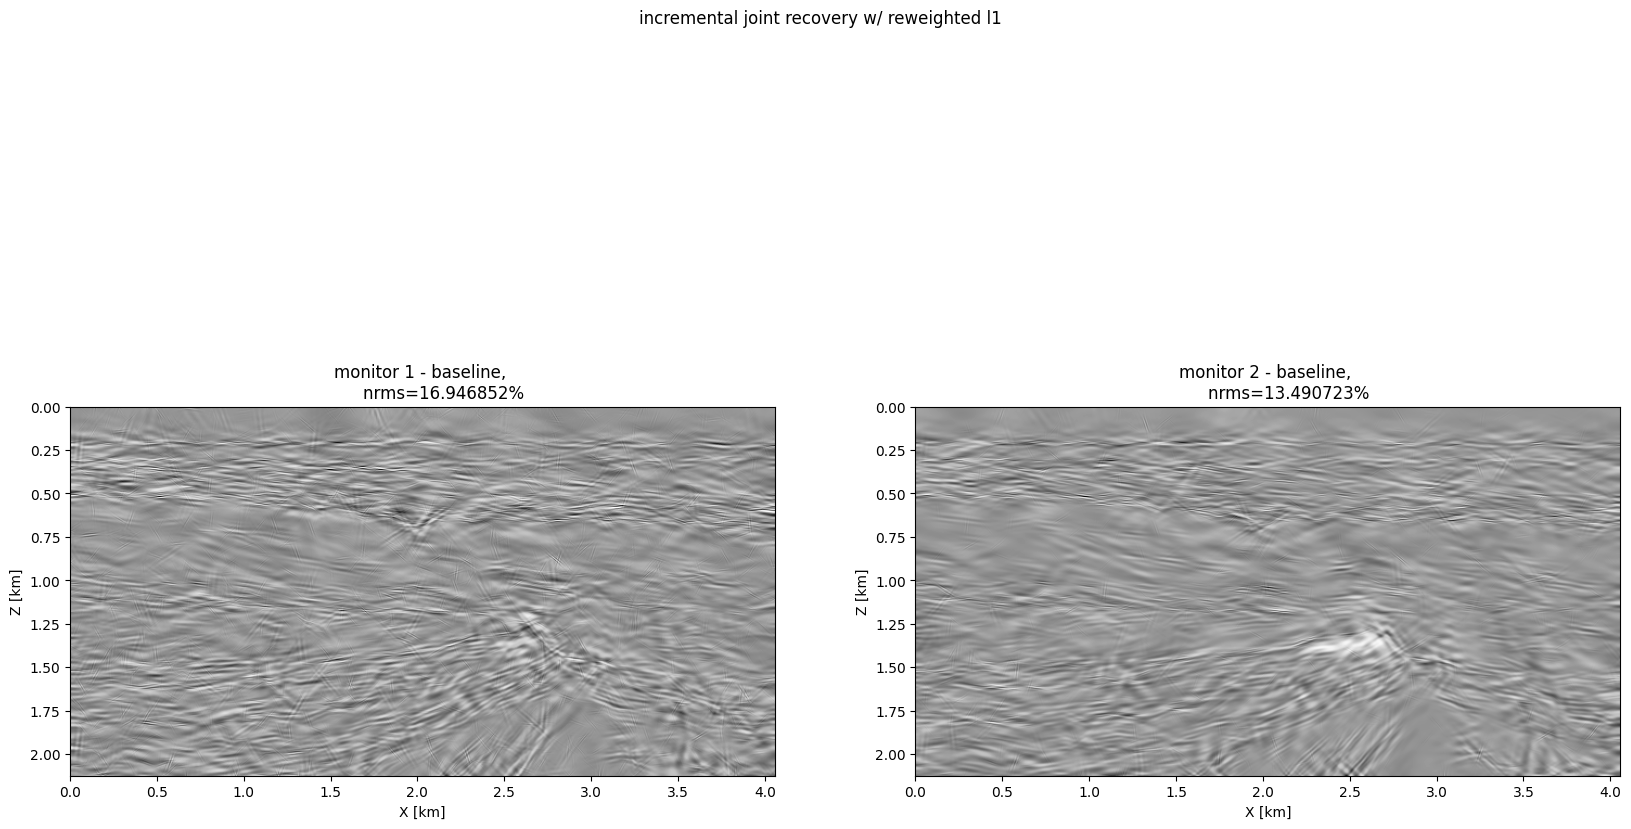

In [27]:
figure(figsize=(20,12));
support = BitVector(undef, size(C,1))
for L = 2:nv    #whenever we received a new survey
    w = ones(Float32, length(support)) - 0.5f0 .* support # support is 0.5, non-support is 1
    W = joDiag(1f0./w; DDT=Complex{Float32}, RDT=Complex{Float32})
    x = [zeros(Float32, size(C,2)) for i = 1:L]
    u1 = [zeros(Complex{Float32}, size(C,1)) for i = 1:L+1]   # thresholded curvelet
    u2 = [zeros(Complex{Float32}, size(C,1)) for i = 1:L+1]   # unthresholded curvelet
    γ = Float32(sqrt(L));
    for j = 1:niter
        r = [A[i]*x[i]-b[i] for i = 1:L]
        g = [W'*C*A[i]'*r[i] for i = 1:L]
        g = [1f0/γ*sum(g), g...]
        t = norm(r)^2/norm(g)^2
        u2 -= t*g
        (j==1) && (L==2) && (global lambda1 = Float32(quantile(abs.(u2[1]), 1.)))
        (j==1) && (L==2) && (global lambda2 = Float32(maximum([quantile(abs.(u2[i]), 1.) for i = 2:L+1])))
        u1[1] = soft_thresholding(u2[1], lambda1)
        u1[2:end] = [soft_thresholding(u2[i], lambda2) for i = 2:L+1]
        @printf("At vintage %d iteration %d function value is %2.2e \n", L, j, 0.5f0*norm(r)^2);
        flush(Base.stdout);
    end
    x = [C'*W*(1f0/γ*u1[1]+u1[i]) for i = 2:L+1]
    for i = 1:L+1
        global support = support .| (abs.(u1[i]).>0f0)
    end
    (L==2) && (global clip=maximum(x[L]-x[1]))
    subplot(1,nv-1,L-1)
    imshow(reshape(x[L]-x[1],n)',extent=(0,extentx/1f3,extentz/1f3,0),
        vmin=-clip,vmax=clip,cmap="Greys");
        xlabel("X [km]");ylabel("Z [km]");title("monitor $(L-1) - baseline, 
        nrms=$(200*norm(reshape(x[L]-x[1],n)[1:300,:])/norm(reshape(x[L]+x[1],n)[1:300,:]))%");
end
suptitle("incremental joint recovery w/ reweighted l1");

We can see that although the first recovery isn't good enough, its information on potential non-zero curvelet location is partially correct. Thus, the support-driven reweighting scheme takes advantage of the support information and we see a better plume after a joint recovery with all vintages. You are encouraged to run these algorithms with more vintages to see how JRM w/ reweighted $\ell_1$ improves the recovery of the CO2 plume.